In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import h5py

import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py

from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error

from nilearn import image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from nilearn.image import resample_to_img, math_img, new_img_like

import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nnt_data

from surfplot import Plot

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
def extract_metadata(filenames):
    pattern = re.compile(
        r"sub-(?P<sub>\d+)_"
        r"ses-(?P<ses>\d+)_"
        r"run-(?P<run>\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"trial-(?P<trial>\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimintensity>\w+)"
    )
    metadata_list = []
    for filename in filenames:
        match = pattern.search(filename)
        if match:
            metadata = match.groupdict()
            metadata_list.append(metadata)
    return pd.DataFrame(metadata_list)

In [3]:
def plot_scores(X_train_r, Y_train_r,
                X_test_r, Y_test_r):

    # 1) On diagonal plot X vs Y scores on each components
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 1")
    plt.ylabel("Y comp. 1")
    plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 2")
    plt.ylabel("Y comp. 2")
    plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    # 2) Off diagonal plot components 1 vs 2 for X and Y
    plt.subplot(222)
    plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("X comp. 1")
    plt.ylabel("X comp. 2")
    plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
              % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(223)
    plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("Y comp. 1")
    plt.ylabel("Y comp. 2")
    plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
              % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [121]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


# 0. load data

# if brain data exists, go to step 6.

In [22]:
imgfname = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz"
ref_img = image.load_img(imgfname)
mask = image.load_img(
    "/dartfs-hpc/rc/lab/C/CANlab/modules/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii"
)
mask_img = masking.compute_epi_mask(
    mask, target_affine=ref_img.affine, target_shape=ref_img.shape
)

# 1) convert to 4d
# original_shape = mask_img.shape  # This should be the spatial shape of the brain volume
# array_4d = array_2d.reshape(original_shape + (-1,))

# # 2) apply masker
# affine = mask_img.affine  # Assuming your data shares the same space as the mask
# func_4d = nib.Nifti1Image(reordered_4d, affine)


# Apply the mask using NiftiMasker
nifti_masker = maskers.NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

masked_func = nifti_masker.fit_transform(ref_img)

In [4]:
singletrial_dir = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy"
task = "*"

# 1. load single trial data from nifti

In [ ]:
import glob
from nilearn import image

# Replace 'your_directory_path' with the path to your NIfTI images
singletrial_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial'
# file_pattern = 'your_directory_path/*.nii.gz' # or '*.nii' depending on your file format
flist = sorted(
    glob.glob(
        join(singletrial_dir, "sub-*", f"*runtype-{task}_event-*_cuetype-*.nii.gz"),
        recursive=True,
    )
)

# Check if you have the expected number of files
print(f"Found {len(flist)} NIfTI files.")

# Load the images (this might take some time depending on the size and number of files)
nifti_images = [image.load_img(f) for f in flist]

# Concatenate the images into a single 4D image
nifti_4d_image = image.concat_imgs(nifti_images)

# nifti_4d_image is now a 4D NIfTI image


In [28]:
from nilearn import image
import numpy as np

# Assuming 'nifti_images' is your list of 3D NIfTI images

# Number of images per chunk
chunk_size = len(nifti_images) // 3

# Create three chunks
chunks = [nifti_images[i:i + chunk_size] for i in range(0, len(nifti_images), chunk_size)]

# Concatenate images in each chunk to create three 4D images
nifti_4d_images = [image.concat_imgs(chunk) for chunk in chunks]

# nifti_4d_images is now a list of three 4D NIfTI images


In [29]:
nifti_4d_images

### save nifti to file

In [ ]:
import nibabel as nib

output_filename = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial'

# Save the image
nifti_4d_image.to_filename(output_filename)

print(f"Image saved as {output_filename}")


# 2. apply nifti

In [9]:
imgfname = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz"
ref_img = image.load_img(imgfname)
mask = image.load_img(
    "/dartfs-hpc/rc/lab/C/CANlab/modules/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii"
)
mask_img = masking.compute_epi_mask(
    mask, target_affine=ref_img.affine, target_shape=ref_img.shape
)

# 1) convert to 4d
# original_shape = mask_img.shape  # This should be the spatial shape of the brain volume
# array_4d = array_2d.reshape(original_shape + (-1,))

# # 2) apply masker
# affine = mask_img.affine  # Assuming your data shares the same space as the mask
# func_4d = nib.Nifti1Image(reordered_4d, affine)


# Apply the mask using NiftiMasker
nifti_masker = maskers.NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

masked_func = nifti_masker.fit_transform(nifti_4d_image)
braindf = masked_func

In [30]:
from nilearn.input_data import NiftiMasker
import pandas as pd

# Assuming you have your mask_img from the previous steps
nifti_masker = NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

# Apply the mask to each 4D image
masked_funcs = [nifti_masker.fit_transform(nifti_4d) for nifti_4d in nifti_4d_images]

# Convert the masked data to DataFrames
braindfs = [pd.DataFrame(masked_func) for masked_func in masked_funcs]

# 'braindfs' is now a list of DataFrames with the masked functional data


/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [34]:
braindfs[0]

,0,1,2,3,4,5,6,7,8,9,...,98043,98044,98045,98046,98047,98048,98049,98050,98051,98052
0,-0.065468,-0.006100,0.207872,0.719617,0.857839,0.239298,-0.134297,0.072514,-0.004950,-0.014550,...,0.235673,-0.039714,0.520198,0.885522,0.945166,0.599040,0.809102,1.375385,1.568981,1.354129
1,-0.696701,-0.192708,-0.733554,-1.553807,-2.172638,-1.982459,-1.449265,-1.033108,0.006843,-0.084132,...,-0.067850,-0.006488,0.310777,-0.205567,-0.617831,-0.599625,0.079734,-0.764778,-1.330110,-1.014080
2,-0.299182,0.087474,0.294977,0.587965,0.348965,-0.520098,-0.759845,0.196799,0.015831,0.060476,...,0.273627,-0.164865,0.101617,0.334117,0.417706,0.020995,0.211310,0.482522,0.420485,0.211810
3,-1.887556,-0.264798,-0.936744,-2.078401,-3.320682,-3.773111,-2.708043,-1.261999,-0.061994,-0.390935,...,0.075916,-0.358835,0.276032,0.127561,-0.322908,-0.734513,0.038448,-0.458549,-0.999117,-1.474578
4,0.833689,0.150017,0.159218,-0.208252,-0.781992,-0.832182,-0.212756,0.172076,0.049549,0.137005,...,-0.254380,-0.389139,-0.273629,-0.375461,-0.339091,-0.316102,-0.144539,-0.126967,-0.115009,0.229037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12947,-4.767931,-1.044272,-1.184932,-1.246495,-2.241564,-4.454995,-6.431962,-6.015547,-1.169536,-1.424569,...,-0.603596,-1.033832,-0.088377,-0.420105,-1.037109,-1.433941,-0.138225,-0.618774,-1.303022,-0.529852
12948,-0.148419,-0.003541,0.097318,0.025484,-0.198400,-0.314225,-0.261375,-0.209107,0.021465,0.056005,...,0.091459,0.195052,-0.005442,0.002714,0.053097,0.119958,-0.011040,-0.002078,0.045369,0.008035
12949,0.237772,0.161378,0.250422,0.224374,0.139092,0.188979,0.233989,0.093746,0.185128,0.188033,...,0.162999,0.326394,0.016262,0.051761,0.157362,0.273584,0.014730,0.037402,0.107196,0.001964
12950,0.238433,0.133298,0.064068,0.020866,0.084770,0.183017,0.141888,-0.075141,0.230925,0.256505,...,0.087375,0.166809,0.012338,0.042627,0.080004,0.091403,0.010320,0.045055,0.086856,0.020651


In [42]:
concatenated_df = pd.concat(braindfs, axis=0)

# Convert the concatenated DataFrame to a NumPy array
braindf = concatenated_df.to_numpy()

In [43]:
braindf.shape

(38856, 98053)

# 3. for given brain data, find behavioral data

In [37]:
print("3. for given brain data, find behavioral data")
pattern = re.compile(r"sub-(\d+).*ses-(\d+).*run-(\d+)")
unique_combinations = set()  # Extract unique combinations using a set to store them
# flist = metadata['filelist']
for file in flist:
    match = pattern.search(file)
    if match:
        # Extract sub, ses, and run numbers and add to the set as a tuple
        unique_combinations.add(
            (int(match.group(1)), int(match.group(2)), int(match.group(3)))
        )
        
unique_combinations_list = sorted(list(unique_combinations))

# print(unique_combinations_list)

3. for given brain data, find behavioral data


In [38]:
unique_combinations_list[:6]

[(2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 5), (2, 3, 6), (2, 4, 1)]

# 4. load behavioral file

In [39]:
# beh_dir = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/beh/beh03_bids"  # 
beh_dir = "/Volumes/spacetop_projects_cue/data/beh/beh03_bids"
beh_dfs = []
for sub, ses, run in sorted(unique_combinations_list):
    beh_pattern = join(
        beh_dir,
        f"sub-{sub:04d}",
        f"ses-{ses:02d}",
        f"sub-{sub:04d}_ses-{ses:02d}_task-cue_*run-{run:02d}_runtype-*_events.tsv",
    )
    beh_files = glob.glob(beh_pattern)
    if beh_files:
        beh_fname = beh_files[0]
        bdf = pd.read_csv(
            beh_fname, sep="\t"
        )  # Make sure to use the correct separator, e.g., '\t' for TSV files
        beh_dfs.append(bdf)

stacked_df = pd.concat(beh_dfs, ignore_index=True)

# basenames = [os.path.basename(fpath) for fpath in flist]
# matching_rows = stacked_df[stacked_df['singletrial_fname'].isin(basenames)]


basenames = [os.path.basename(fpath).replace(".nii.gz", "") for fpath in flist]
# Remove the '.nii.gz' extension from 'singletrial_fname' in the DataFrame
stacked_df["singletrial_fname_no_ext"] = stacked_df["singletrial_fname"].str.replace(
    ".nii.gz", "", regex=False
)
# Now, find the rows in the DataFrame where singletrial_fname_no_ext matches the basenames without extension
intersection_beh = stacked_df[stacked_df["singletrial_fname_no_ext"].isin(basenames)]


In [40]:
intersection_beh.head()

,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext
0,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,low_cue,low_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
1,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,high_cue,med_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
2,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,high_cue,low_stim,53.370840,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
3,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,high_cue,high_stim,36.869898,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...
4,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,low_cue,med_stim,32.254711,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...


# 5. merge brain and behavioral data

In [41]:
print("5. merge brain and behavioral data")
import os
import pandas as pd

# Assuming 'df' is your existing DataFrame with a 'singletrial_fname' column
# And 'flist' is your list of file paths
# 1) Remove the '.npy' extension and sort the list
# 2) Create a DataFrame from sorted basenames
# 3) Remove the '.nii.gz' extension from 'singletrial_fname' and sort the DataFrame
sorted_basenames = sorted(os.path.basename(f).replace(".nii.gz", "") for f in flist)
basenames_df = pd.DataFrame(sorted_basenames, columns=["basename"])
stacked_df["basename"] = stacked_df["singletrial_fname"].str.replace(
    ".nii.gz", "", regex=False
)
sorted_df = stacked_df.sort_values(by="basename").reset_index(drop=True)

# Merge the two DataFrames based on the basename to ensure the order is the same
merged_df = pd.merge(basenames_df, sorted_df, on="basename", how="left")
print(merged_df)

5. merge brain and behavioral data
                                                basename      onset  duration  \
0      sub-0002_ses-03_run-01_runtype-vicarious_event...   11.61111       1.0   
1      sub-0002_ses-03_run-01_runtype-vicarious_event...   42.40593       1.0   
2      sub-0002_ses-03_run-01_runtype-vicarious_event...   74.20112       1.0   
3      sub-0002_ses-03_run-01_runtype-vicarious_event...  110.61470       1.0   
4      sub-0002_ses-03_run-01_runtype-vicarious_event...  139.90896       1.0   
...                                                  ...        ...       ...   
38851  sub-0133_ses-04_run-06_runtype-cognitive_event...  244.91100       5.0   
38852  sub-0133_ses-04_run-06_runtype-cognitive_event...  280.80772       5.0   
38853  sub-0133_ses-04_run-06_runtype-cognitive_event...  307.90116       5.0   
38854  sub-0133_ses-04_run-06_runtype-cognitive_event...  342.89754       5.0   
38855  sub-0133_ses-04_run-06_runtype-cognitive_event...  376.20997       

In [15]:
merged_df["stim_con"] = merged_df["stimtype"].replace(
    {"high_stim": 1, "med_stim": 0, "low_stim": -1}
)

In [16]:
assert len(braindf) == len(
    merged_df
), "The matrix and dataframe must have the same number of rows"
# Create a new column in 'merged_df' that uniquely identifies each session
merged_df["session_id"] = (
    merged_df[["sub", "ses", "run"]].astype(str).agg("_".join, axis=1)
)

# Prepare an array to hold the z-scored brain data
zscored_braindf = np.empty_like(braindf)
# Assuming 'run_id' is a column in 'merged_df' that uniquely identifies each run
# and 'braindf' is a pandas DataFrame with the same index as 'merged_df'
# Create an array to hold the column means for each run
column_means_per_run = np.zeros_like(braindf)
session_ids = merged_df["session_id"].unique()

# Calculate the column means for each run and fill NaN values
for session_id in session_ids:
    indices = np.where(merged_df["session_id"] == session_id)[
        0
    ]  # Get the indices for the current run
    column_means = np.nanmean(
        braindf[indices], axis=0
    )  # Calculate the mean of each column for the current run, ignoring NaNs
    # If a whole column is NaNs, fill it with zeros or a global mean if preferred
    column_means = np.nan_to_num(
        column_means, nan=0.0
    )  # or replace 0.0 with a global mean
    # Assign the means to the corresponding places in the column means array
    column_means_per_run[indices] = column_means
# Where braindf is NaN, fill in the values from column_means_per_run
braindf_filled = np.where(np.isnan(braindf), column_means_per_run, braindf)

# plot brain data

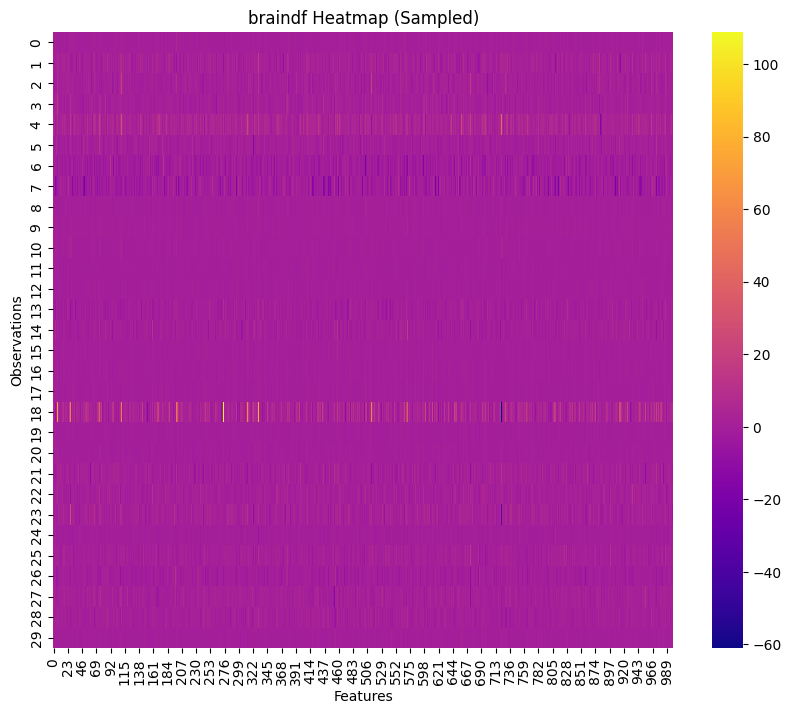

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming braindf_filled is a NumPy array
n_rows, n_cols = braindf.shape

# Number of rows and columns to sample
sample_size_rows = 30  # Adjust as needed
sample_size_cols = 1000  # Adjust as needed

# Randomly choose indices
rows_indices = np.random.choice(n_rows, sample_size_rows, replace=False)
cols_indices = np.random.choice(n_cols, sample_size_cols, replace=False)

# Sample the array
sampled_array = braindf[np.ix_(rows_indices, cols_indices)]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(sampled_array, cmap="plasma", cbar=True)
plt.title("braindf Heatmap (Sampled)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


## save brain data

In [55]:
import h5py

# Assuming 'your_array' is your NumPy array

with h5py.File('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.h5', 'w') as hdf:
    hdf.create_dataset('singletrial', data=braindf)


### save behavioral data

In [58]:
import pandas as pd

# Assuming 'df' is your DataFrame
merged_df.to_csv('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.csv', index=False)  # Set index=False if you don't want to save the index


# 6. load brain/beh data

Here, I'm loading the saved brain and behavioral data. 
This was accomplished using steps 1,2,3,4,5 listed above.
The brain data is shaped (single trial, voxel).
Note that the voxels are smaller than the native space cube size, give that we masked out the non-brain voxels.
We can always inverse mask and revert back to nifti native space using nifti masker object.

As for the brain data, the shape is (single trial, behavioral regressors)


In [4]:
with h5py.File('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.h5', 'r') as hdf:
    braindf_test = hdf['singletrial'][:]


In [5]:
braindf_test.shape

(38856, 98053)

In [6]:
braindf = braindf_test

In [7]:
merged_df = pd.read_csv('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.csv')


In [8]:
print(merged_df.shape)
merged_df.head()

(38856, 20)


,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext,pain_cue,vic_cue,cog_cue,gen_cue
0,sub-0002_ses-03_run-01_runtype-vicarious_event...,11.61111,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,0,low_cue,low_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1
1,sub-0002_ses-03_run-01_runtype-vicarious_event...,42.40593,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,1,high_cue,med_stim,NaN,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
2,sub-0002_ses-03_run-01_runtype-vicarious_event...,74.20112,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,2,high_cue,low_stim,53.370840,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
3,sub-0002_ses-03_run-01_runtype-vicarious_event...,110.61470,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,3,high_cue,high_stim,36.869898,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,1,0,1
4,sub-0002_ses-03_run-01_runtype-vicarious_event...,139.90896,1.0,cue,sub-0002,ses-03,run-01,vicarious,cue,4,low_cue,med_stim,32.254711,NaN,sub-0002_ses-03_run-01_runtype-vicarious_event...,sub-0002_ses-03_run-01_runtype-vicarious_event...,0,-1,0,-1


# 6. TST load brain/beh data: use parcellated data for speed, for now

In [4]:
current_dir = os.getcwd()
current_dir
main_dir = Path(current_dir).parents[2]
braindf = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.npy'))
print(f"the shape of the parcel data {braindf.shape}")
df_final = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.tsv'), sep='\t')

schaefer = nnt_data.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


the shape of the parcel data (20029, 400)


In [5]:
import glob
from nilearn import image
task = 'pain'
# Replace 'your_directory_path' with the path to your NIfTI images
# singletrial_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial'
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial'
# file_pattern = 'your_directory_path/*.nii.gz' # or '*.nii' depending on your file format
flist = sorted(
    glob.glob(
        join(singletrial_dir, "sub-*", f"*runtype-{task}_event-*_cuetype-*.nii.gz"),
        recursive=True,
    )
)
print("3. for given brain data, find behavioral data")
pattern = re.compile(r"sub-(\d+).*ses-(\d+).*run-(\d+)")
unique_combinations = set()  # Extract unique combinations using a set to store them
# flist = metadata['filelist']
for file in flist:
    match = pattern.search(file)
    if match:
        # Extract sub, ses, and run numbers and add to the set as a tuple
        unique_combinations.add(
            (int(match.group(1)), int(match.group(2)), int(match.group(3)))
        )
        
unique_combinations_list = sorted(list(unique_combinations))

# print(unique_combinations_list)
# beh_dir = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/beh/beh03_bids"  # 
beh_dir = "/Volumes/spacetop_projects_cue/data/beh/beh03_bids"
beh_dfs = []
for sub, ses, run in sorted(unique_combinations_list):
    beh_pattern = join(
        beh_dir,
        f"sub-{sub:04d}",
        f"ses-{ses:02d}",
        f"sub-{sub:04d}_ses-{ses:02d}_task-cue_*run-{run:02d}_runtype-*_events.tsv",
    )
    beh_files = glob.glob(beh_pattern)
    if beh_files:
        beh_fname = beh_files[0]
        bdf = pd.read_csv(
            beh_fname, sep="\t"
        )  # Make sure to use the correct separator, e.g., '\t' for TSV files
        beh_dfs.append(bdf)

stacked_df = pd.concat(beh_dfs, ignore_index=True)


3. for given brain data, find behavioral data


In [6]:
stacked_df.head()

,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,cuetype,stimtype,expectrating,outcomerating,singletrial_fname
0,10.57958,1.0,cue,sub-0002,ses-03,run-02,pain,cue,0,low_cue,low_stim,38.118276,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
1,35.68895,1.0,cue,sub-0002,ses-03,run-02,pain,cue,1,low_cue,med_stim,25.523425,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
2,61.28182,1.0,cue,sub-0002,ses-03,run-02,pain,cue,2,low_cue,low_stim,60.284232,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
3,91.27634,1.0,cue,sub-0002,ses-03,run-02,pain,cue,3,low_cue,high_stim,37.106656,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...
4,119.98705,1.0,cue,sub-0002,ses-03,run-02,pain,cue,4,high_cue,med_stim,113.892502,NaN,sub-0002_ses-03_run-02_runtype-pain_event-cue_...


In [7]:
stacked_df.shape

(24096, 14)

In [8]:
df_final

,filename,sub,ses,run,runtype,event,trial,cuetype,stimintensity,groupsinterim
0,sub-0117_ses-01_run-02_runtype-cognitive_event...,sub-0117,1,2,cognitive,stimulus,6,low,med,1
1,sub-0117_ses-01_run-05_runtype-cognitive_event...,sub-0117,1,5,cognitive,stimulus,10,high,med,1
2,sub-0117_ses-01_run-05_runtype-cognitive_event...,sub-0117,1,5,cognitive,stimulus,1,high,low,1
3,sub-0117_ses-01_run-06_runtype-vicarious_event...,sub-0117,1,6,vicarious,stimulus,4,low,low,1
4,sub-0117_ses-01_run-01_runtype-vicarious_event...,sub-0117,1,1,vicarious,stimulus,4,high,high,1
...,...,...,...,...,...,...,...,...,...,...
20024,sub-0111_ses-04_run-06_runtype-pain_event-stim...,sub-0111,4,6,pain,stimulus,7,high,high,112
20025,sub-0111_ses-03_run-05_runtype-vicarious_event...,sub-0111,3,5,vicarious,stimulus,0,high,med,112
20026,sub-0111_ses-03_run-03_runtype-cognitive_event...,sub-0111,3,3,cognitive,stimulus,10,low,low,112
20027,sub-0111_ses-04_run-03_runtype-cognitive_event...,sub-0111,4,3,cognitive,stimulus,9,low,med,112


In [9]:
merged_df = pd.merge(df_final, stacked_df, left_on='filename', right_on='singletrial_fname', how='inner')


In [10]:
merged_df.head()

,filename,sub_x,ses_x,run_x,runtype_x,event,trial,cuetype_x,stimintensity,groupsinterim,...,ses_y,run_y,runtype_y,eventtype,trialnum,cuetype_y,stimtype,expectrating,outcomerating,singletrial_fname
0,sub-0117_ses-01_run-03_runtype-pain_event-stim...,sub-0117,1,3,pain,stimulus,6,high,low,1,...,ses-01,run-03,pain,stimulus,6,high_cue,low_stim,NaN,NaN,sub-0117_ses-01_run-03_runtype-pain_event-stim...
1,sub-0117_ses-01_run-03_runtype-pain_event-stim...,sub-0117,1,3,pain,stimulus,2,low,med,1,...,ses-01,run-03,pain,stimulus,2,low_cue,med_stim,NaN,67.801016,sub-0117_ses-01_run-03_runtype-pain_event-stim...
2,sub-0117_ses-01_run-03_runtype-pain_event-stim...,sub-0117,1,3,pain,stimulus,10,low,high,1,...,ses-01,run-03,pain,stimulus,10,low_cue,high_stim,NaN,NaN,sub-0117_ses-01_run-03_runtype-pain_event-stim...
3,sub-0117_ses-01_run-03_runtype-pain_event-stim...,sub-0117,1,3,pain,stimulus,3,low,high,1,...,ses-01,run-03,pain,stimulus,3,low_cue,high_stim,70.981908,NaN,sub-0117_ses-01_run-03_runtype-pain_event-stim...
4,sub-0117_ses-01_run-04_runtype-pain_event-stim...,sub-0117,1,4,pain,stimulus,9,low,med,1,...,ses-01,run-04,pain,stimulus,9,low_cue,med_stim,NaN,NaN,sub-0117_ses-01_run-04_runtype-pain_event-stim...


In [11]:
merged_df.columns


Index(['filename', 'sub_x', 'ses_x', 'run_x', 'runtype_x', 'event', 'trial',
       'cuetype_x', 'stimintensity', 'groupsinterim', 'onset', 'duration',
       'trial_type', 'sub_y', 'ses_y', 'run_y', 'runtype_y', 'eventtype',
       'trialnum', 'cuetype_y', 'stimtype', 'expectrating', 'outcomerating',
       'singletrial_fname'],
      dtype='object')

## load NPS

In [12]:
nps_fname = join(main_dir, 'analysis/fmri/nilearn/deriv01_signature/rampupdown/signature-NPSpos_sub-all_runtype-pvc_event-stimulus.tsv')
npsdf = pd.read_csv(nps_fname, sep=',')

In [13]:
npsdf.head()

,Unnamed: 0,singletrial_fname,NPSpos
0,0,sub-0002_ses-01_run-01_runtype-pain_event-stim...,25.957941
1,1,sub-0002_ses-01_run-01_runtype-pain_event-stim...,29.994260
2,2,sub-0002_ses-01_run-01_runtype-pain_event-stim...,41.527786
3,3,sub-0002_ses-01_run-01_runtype-pain_event-stim...,48.601646
4,4,sub-0002_ses-01_run-01_runtype-pain_event-stim...,48.478947


In [14]:
beh_nps = pd.merge(merged_df, npsdf, left_on='filename', right_on='singletrial_fname', how='inner')
beh_nps.columns

Index(['filename', 'sub_x', 'ses_x', 'run_x', 'runtype_x', 'event', 'trial',
       'cuetype_x', 'stimintensity', 'groupsinterim', 'onset', 'duration',
       'trial_type', 'sub_y', 'ses_y', 'run_y', 'runtype_y', 'eventtype',
       'trialnum', 'cuetype_y', 'stimtype', 'expectrating', 'outcomerating',
       'singletrial_fname_x', 'Unnamed: 0', 'singletrial_fname_y', 'NPSpos'],
      dtype='object')

In [40]:
behNPSdf = beh_nps.drop(columns=['singletrial_fname_x','singletrial_fname_y', 'cuetype_x', 'Unnamed: 0', 'sub_x', 'ses_x', 'run_x', 'runtype_x', 'stimintensity'])
behNPS_df = behNPSdf.rename({'sub_y': 'sub',
'ses_y':'ses',
'run_y': 'run',
'runtype_y': 'runtype',
'cuetype_y': 'cuetype'} )

In [19]:
## drop rows from brain df based on intersection of and behNPS_DF
df_final = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.tsv'), sep='\t')


In [41]:
behNPS_df.head()

,filename,event,trial,groupsinterim,onset,duration,trial_type,sub_y,ses_y,run_y,runtype_y,eventtype,trialnum,cuetype_y,stimtype,expectrating,outcomerating,NPSpos
0,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,6,1,187.31058,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,6,high_cue,low_stim,NaN,NaN,1.747426
1,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,2,1,75.12588,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,2,low_cue,med_stim,NaN,67.801016,13.301759
2,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,10,1,330.84069,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,10,low_cue,high_stim,NaN,NaN,4.326265
3,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,3,1,104.11876,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,3,low_cue,high_stim,70.981908,NaN,8.228300
4,sub-0117_ses-01_run-04_runtype-pain_event-stim...,stimulus,9,1,314.52442,5.0,stimulus,sub-0117,ses-01,run-04,pain,stimulus,9,low_cue,med_stim,NaN,NaN,3.628740


In [21]:
df_final.head()

,filename,sub,ses,run,runtype,event,trial,cuetype,stimintensity,groupsinterim
0,sub-0117_ses-01_run-02_runtype-cognitive_event...,sub-0117,1,2,cognitive,stimulus,6,low,med,1
1,sub-0117_ses-01_run-05_runtype-cognitive_event...,sub-0117,1,5,cognitive,stimulus,10,high,med,1
2,sub-0117_ses-01_run-05_runtype-cognitive_event...,sub-0117,1,5,cognitive,stimulus,1,high,low,1
3,sub-0117_ses-01_run-06_runtype-vicarious_event...,sub-0117,1,6,vicarious,stimulus,4,low,low,1
4,sub-0117_ses-01_run-01_runtype-vicarious_event...,sub-0117,1,1,vicarious,stimulus,4,high,high,1


In [22]:
brain_behNPS_filtered = df_final[df_final['filename'].isin(behNPS_df.filename)]


In [23]:
print(f"brain df shape: {braindf.shape}")
print(f"behavioral NPS intersection shape: {behNPS_df.shape}")
print(f"brain df after intersection of behNPS: {brain_behNPS_filtered.shape}")


brain df shape: (20029, 400)
behavioral NPS intersection shape: (5965, 18)
brain df after intersection of behNPS: (5965, 10)


In [27]:
brain_behNPS_filtered.filename.reset_index().drop(columns='index')

,filename
0,sub-0117_ses-01_run-03_runtype-pain_event-stim...
1,sub-0117_ses-01_run-03_runtype-pain_event-stim...
2,sub-0117_ses-01_run-03_runtype-pain_event-stim...
3,sub-0117_ses-01_run-03_runtype-pain_event-stim...
4,sub-0117_ses-01_run-04_runtype-pain_event-stim...
...,...
5960,sub-0111_ses-03_run-04_runtype-pain_event-stim...
5961,sub-0111_ses-04_run-01_runtype-pain_event-stim...
5962,sub-0111_ses-04_run-01_runtype-pain_event-stim...
5963,sub-0111_ses-03_run-02_runtype-pain_event-stim...


In [28]:
checkindex1 = brain_behNPS_filtered.filename.reset_index().drop(columns='index')
checkindex2 = behNPS_df.filename.reset_index().drop(columns='index')
checkindex1 == checkindex2


,filename
0,True
1,True
2,True
3,True
4,True
...,...
5960,True
5961,True
5962,True
5963,True


In [29]:
np.sum(checkindex1 == checkindex2)

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


filename    5965
dtype: int64

In [42]:
brain_behNPS_filtered.index

Index([    9,    10,    11,    12,    13,    17,    22,    25,    30,    32,
       ...
       20009, 20010, 20011, 20012, 20014, 20015, 20019, 20020, 20021, 20024],
      dtype='int64', length=5965)

In [36]:
behNPS_filtered = behNPS_df.reset_index()
brain_filtered = braindf[brain_behNPS_filtered.index, :]
print(f"brain data after filtering out: {brain_filtered.shape}")

brain data after filtering out: (5965, 400)


In [37]:
behNPS_filtered

,index,filename,event,trial,groupsinterim,onset,duration,trial_type,sub_y,ses_y,run_y,runtype_y,eventtype,trialnum,cuetype_y,stimtype,expectrating,outcomerating,NPSpos
0,0,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,6,1,187.31058,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,6,high_cue,low_stim,NaN,NaN,1.747426
1,1,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,2,1,75.12588,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,2,low_cue,med_stim,NaN,67.801016,13.301759
2,2,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,10,1,330.84069,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,10,low_cue,high_stim,NaN,NaN,4.326265
3,3,sub-0117_ses-01_run-03_runtype-pain_event-stim...,stimulus,3,1,104.11876,5.0,stimulus,sub-0117,ses-01,run-03,pain,stimulus,3,low_cue,high_stim,70.981908,NaN,8.228300
4,4,sub-0117_ses-01_run-04_runtype-pain_event-stim...,stimulus,9,1,314.52442,5.0,stimulus,sub-0117,ses-01,run-04,pain,stimulus,9,low_cue,med_stim,NaN,NaN,3.628740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5960,5960,sub-0111_ses-03_run-04_runtype-pain_event-stim...,stimulus,5,112,193.60724,5.0,stimulus,sub-0111,ses-03,run-04,pain,stimulus,5,low_cue,high_stim,83.506475,146.437256,8.026141
5961,5961,sub-0111_ses-04_run-01_runtype-pain_event-stim...,stimulus,0,112,16.60434,5.0,stimulus,sub-0111,ses-04,run-01,pain,stimulus,0,low_cue,high_stim,63.332268,61.279673,-35.151382
5962,5962,sub-0111_ses-04_run-01_runtype-pain_event-stim...,stimulus,2,112,86.02491,5.0,stimulus,sub-0111,ses-04,run-01,pain,stimulus,2,low_cue,low_stim,44.183876,60.340891,-13.456852
5963,5963,sub-0111_ses-03_run-02_runtype-pain_event-stim...,stimulus,1,112,45.42497,5.0,stimulus,sub-0111,ses-03,run-02,pain,stimulus,1,low_cue,med_stim,21.202819,86.293711,-6.708570


# plot behavioral data

We're going to grab a subset of regressors. Here's just a demo of the regressors we can grab.
It has 
* 1) stimulus, inserted as a contrast code,
* 2) expectation rating, not yet z scored
* 3) outcome rating, not yet z scored.


In [53]:
print(f"column names: {behNPS_df.columns}")
print(f"take a look at the beh + NPS dataframe: {behNPS_df.head()}")

column names: Index(['filename', 'event', 'trial', 'groupsinterim', 'onset', 'duration',
       'trial_type', 'sub_y', 'ses_y', 'run_y', 'runtype_y', 'eventtype',
       'trialnum', 'cuetype_y', 'stimtype', 'expectrating', 'outcomerating',
       'NPSpos', 'stim_con'],
      dtype='object')
take a look at the beh + NPS dataframe:                                             filename     event  trial  \
0  sub-0117_ses-01_run-03_runtype-pain_event-stim...  stimulus      6   
1  sub-0117_ses-01_run-03_runtype-pain_event-stim...  stimulus      2   
2  sub-0117_ses-01_run-03_runtype-pain_event-stim...  stimulus     10   
3  sub-0117_ses-01_run-03_runtype-pain_event-stim...  stimulus      3   
4  sub-0117_ses-01_run-04_runtype-pain_event-stim...  stimulus      9   

   groupsinterim      onset  duration trial_type     sub_y   ses_y   run_y  \
0              1  187.31058       5.0   stimulus  sub-0117  ses-01  run-03   
1              1   75.12588       5.0   stimulus  sub-0117  ses-01  run-0

In [52]:
behNPS_df['stim_con'] = behNPS_df['stimtype'].replace({'high_stim':1, 
                                           'med_stim':0, 
                                           'low_stim':-1})

In [69]:
Xinterim = behNPS_df
# [
#     ["stim_con", "expectrating", "outcomerating", "NPSpos"]
# ] 
# TODO: create dummy variables for pain, vicarious, cognitive, general stim
# TODO: create dummy variables for pain, vicarious, cognitive high cue gt low cue

Yinterim = brain_filtered  # zscored_braindf  # np.random.randn(89, 1)      # Replace with your actual data
# identify groups
from collections import Counter

subject_ids = [int(re.search(r"sub-(\d+)", fname).group(1)) for fname in flist]
subject_counts = Counter(subject_ids)  # Count the occurrences of each subject
factorized_ids, unique_ids = pd.factorize(subject_ids)
groupsinterim = (
    factorized_ids + 1
) 




/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/3202962666.py:14: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  factorized_ids, unique_ids = pd.factorize(subject_ids)


In [70]:
# remove nan values from X, Y, groups
import pandas as pd

# Assuming df_main is your primary DataFrame
nan_rows = Xinterim[Xinterim.isnull().any(axis=1)]
X_dropna = Xinterim.dropna()

Y_dropna= Yinterim[X_dropna.index.to_numpy()]
groups_dropna = groupsinterim[X_dropna.index.to_numpy()]


In [71]:
print(f"X: {Xinterim.shape} after dropping -> {X_dropna.shape}")
print(f"Y: {Yinterim.shape} after dropping -> {Y_dropna.shape}")
print(f"groups: {groupsinterim.shape} after dropping -> {groups_dropna.shape}")

X: (5965, 19) after dropping -> (5067, 19)
Y: (5965, 400) after dropping -> (5067, 400)
groups: (12048,) after dropping -> (5067,)


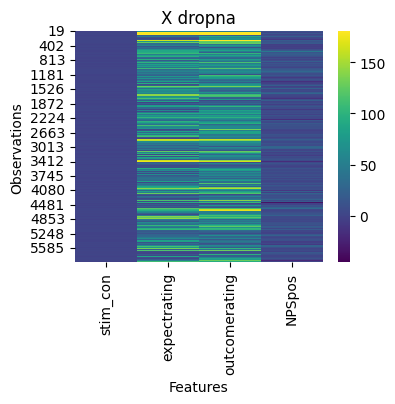

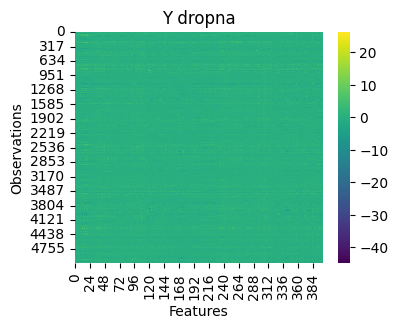

In [83]:

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(X_dropna[["stim_con", "expectrating", "outcomerating", "NPSpos"]], cmap="viridis", cbar=True)
plt.title("X dropna")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

plt.figure(figsize=(4,3))
sns.heatmap(Y_dropna, cmap="viridis", cbar=True)
plt.title("Y dropna")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


## B.3 PLS for PVC cue contrast

In [88]:
X_dropna.columns

Index(['filename', 'event', 'trial', 'groupsinterim', 'onset', 'duration',
       'trial_type', 'sub_y', 'ses_y', 'run_y', 'runtype_y', 'eventtype',
       'trialnum', 'cuetype_y', 'stimtype', 'expectrating', 'outcomerating',
       'NPSpos', 'stim_con', 'dummy_pain', 'dummy_general'],
      dtype='object')

In [90]:
X = Y_dropna
Y = X_dropna[["stim_con", "expectrating", "outcomerating", "NPSpos"]]
groups = groups_dropna

outer_cv = GroupKFold(n_splits=5)
pls_model = PLSRegression(n_components=20)
i = 0
inner_scores = []
outer_scores = []
x_weights_per_fold = []
y_weights_per_fold = []
intercepts_per_fold = []
coefficients_per_fold = []

# X = braindf
# Y = reg
for i, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    print(f"________________________________ fold {i} ________________________________")
    X_train, X_test = X[train_val_idx], X[test_idx]
    Y_train, Y_test = Y.iloc[train_val_idx].to_numpy(), Y.iloc[test_idx].to_numpy()
    groups_train_val = groups[train_val_idx]
    print(
        f"train participants: {np.unique(groups[train_val_idx])},test participants: {np.unique(groups[test_idx])}, "
    )
    # Fit the model
    pls_model.fit(X_train, Y_train)

    # Evaluate on the inner validation set
    Y_pred = pls_model.predict(X_test)
    inner_score = mean_squared_error(Y_test, Y_pred)
    inner_scores.append(inner_score)
    # Assuming the nifti_masker has been fitted previously

    x_weights_per_fold.append(pls_model.x_weights_)
    y_weights_per_fold.append(pls_model.y_weights_)

    intercepts_per_fold.append(pls_model.intercept_)
    coefficients_per_fold.append(pls_model.coef_)
    # x_weights_first_component = pls_model.x_weights_[:, 0]
    # y_weights_first_component = pls_model.y_weights_[:, 0]

    # x_weights_second_component = pls_model.x_weights_[:, 1]
    # y_weights_second_component = pls_model.y_weights_[:, 1]

    # x_weights_third_component = pls_model.x_weights_[:, 2]
    # y_weights_third_component = pls_model.y_weights_[:, 2]

#     first_img = nifti_masker.inverse_transform(x_weights_first_component)
#     second_img = nifti_masker.inverse_transform(x_weights_second_component)
#     third_img = nifti_masker.inverse_transform(x_weights_third_component)

________________________________ fold 0 ________________________________
train participants: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 16 17 19 21 22 23 25 27 28 29 30
 31 32 35 36 37 40 41 42 43 44 46 47 48 49 50 51 52 54 55 56 57 58],test participants: [13 15 18 20 24 26 33 34 38 39 45 53], 
________________________________ fold 1 ________________________________
train participants: [ 2  3  4  5  6  7  9 11 12 13 15 17 18 19 20 21 22 23 24 25 26 27 28 31
 32 33 34 35 37 38 39 40 43 44 45 46 47 48 49 50 52 53 55 56 57 58],test participants: [ 1  8 10 14 16 29 30 36 41 42 51 54], 
________________________________ fold 2 ________________________________
train participants: [ 1  3  4  5  6  7  8 10 11 12 13 14 15 16 18 20 22 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 50 51 52 53 54 56],test participants: [ 2  9 17 19 21 23 43 49 55 57 58], 
________________________________ fold 3 ________________________________
train participants: [ 1  2  3  6  8  9 10 13 14 

## B.4 visualization

### B.4.a scores

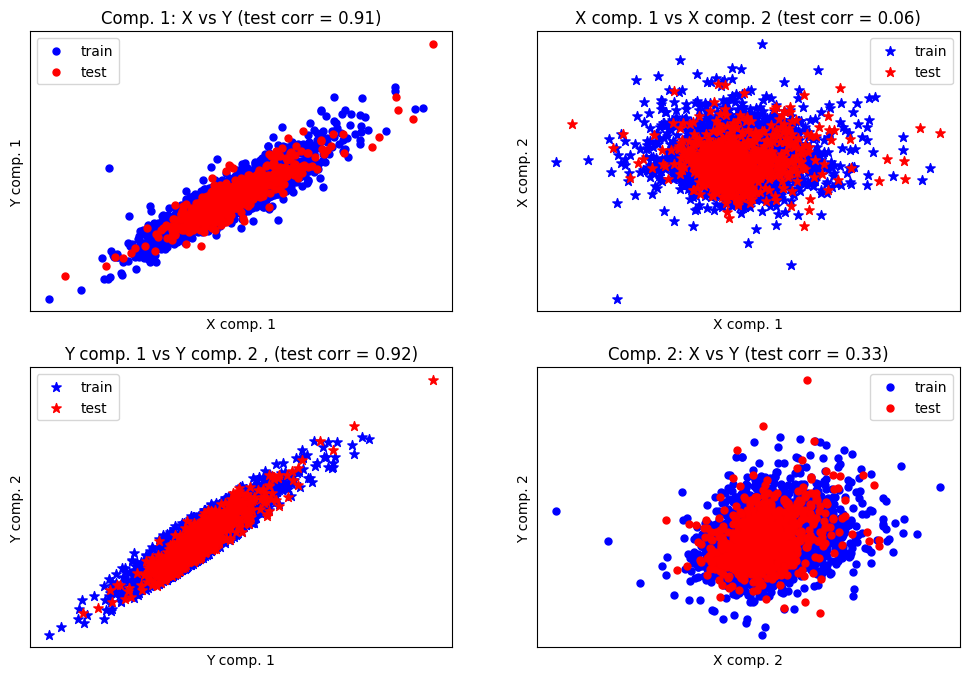

In [156]:
X_train_r, Y_train_r = pls_model.transform(X_train, Y_train)
X_test_r, Y_test_r = pls_model.transform(X_test, Y_test)
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

### B.4.b plot loadings

Text(0.5, 1.0, 'PLS Scores Plot')

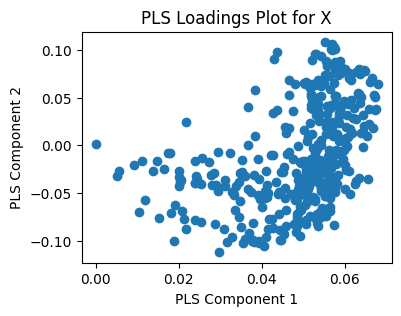

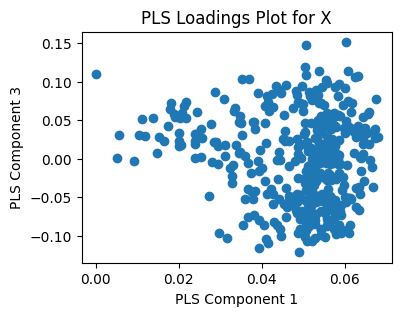

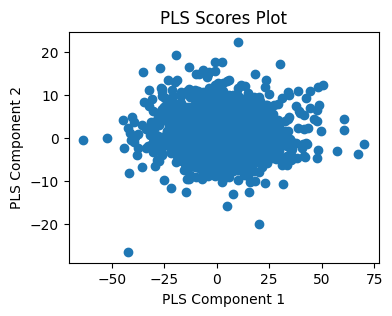

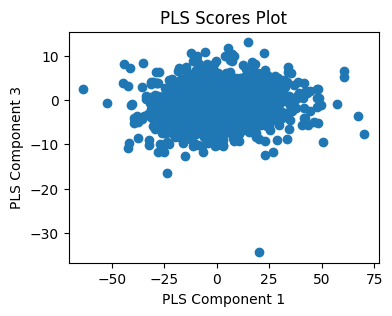

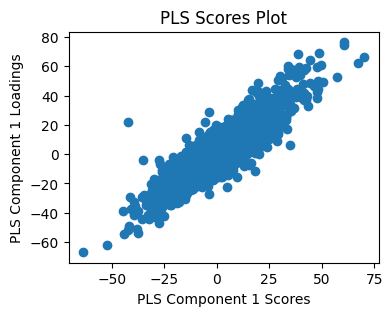

In [101]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Assume X and Y are your data

# Fit the PLS model
# pls = PLSRegression(n_components=2)
# pls.fit(X, Y)

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Loadings plot for X
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 1])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 2])
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 3')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()

# Scores plot
plt.figure(figsize=(4,3))
plt.scatter(pls_model.x_scores_[:, 0], pls_model.y_scores_[:, 0])
plt.xlabel('PLS Component 1 Scores')
plt.ylabel('PLS Component 1 Loadings')
plt.title('PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()


## 3d plot

Text(0.5, 0.92, '3D PLS Scores Plot')

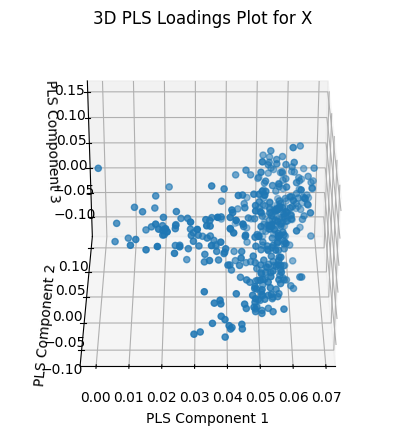

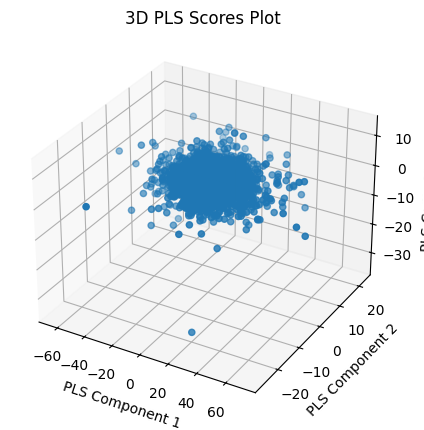

In [170]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.cross_decomposition import PLSRegression

# Assume X and Y are your data
# Assume pls_model is your trained PLSRegression model

# Loadings plot for X in 3D
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=270) # Adjust these values to change the rotation

ax.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1], pls_model.x_loadings_[:, 2])
ax.set_xlabel('PLS Component 1')
ax.set_ylabel('PLS Component 2')
ax.set_zlabel('PLS Component 3')
ax.set_title('3D PLS Loadings Plot for X')
# You can annotate points with variable names here
# plt.show()

# Scores plot in 3D
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 1], pls_model.x_scores_[:, 2])
ax.set_xlabel('PLS Component 1')
ax.set_ylabel('PLS Component 2')
ax.set_zlabel('PLS Component 3')
ax.set_title('3D PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()


## umap plot

In [191]:
Y.shape

(5067, 4)

In [188]:
pls_model.x_scores_.shape

(4052, 20)

In [192]:
sns.pairplot(pd.DataFrame(pls_model.x_scores_.T))

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/2311709949.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)


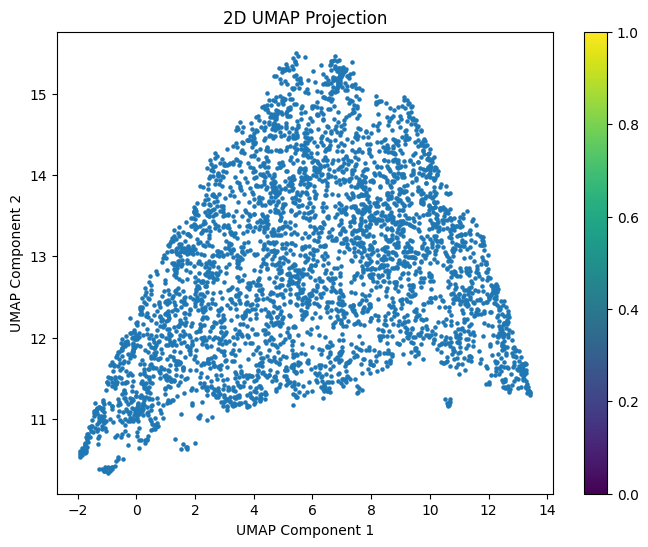

In [176]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assume 'data' is your dataset with many components (e.g., 20)

# Initialize and fit UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(pls_model.x_scores_)

# Plotting the 2D visualization
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.title('2D UMAP Projection')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar()
plt.show()


In [183]:
embedding_3d.shape

(4052, 3)

PLS model X scores: (4052, 20)


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Embedding 3d: (4052, 3)


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/950896571.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], cmap='Spectral', s=5)


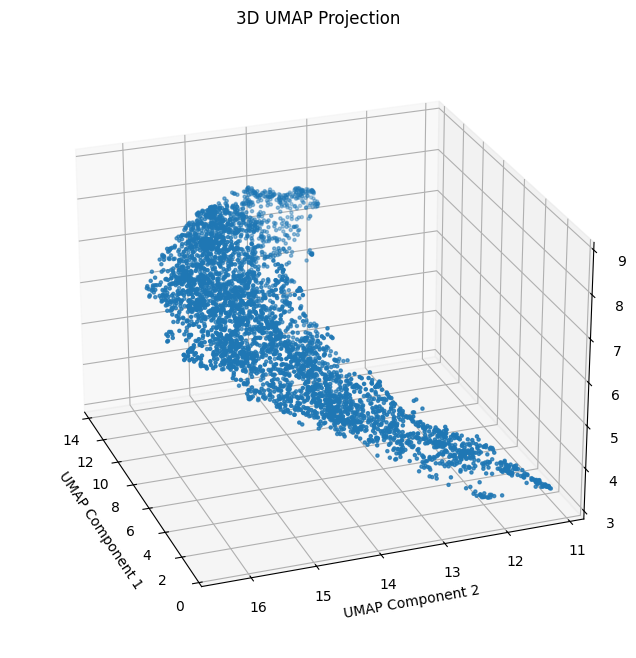

In [185]:
from mpl_toolkits.mplot3d import Axes3D

print(f">>> * PLS model X scores: {pls_model.x_scores_.shape}")
# Initialize and fit UMAP for 3D
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(pls_model.x_scores_)
print(f">>> * Embedding 3d: {embedding_3d.shape}")
# Plotting the 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=160) # Adjust these values to change the rotation
scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], cmap='Spectral', s=5)
ax.set_title('3D UMAP Projection')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.show()


### B.4.c VIP scores

Variable Importance in Projection (VIP) scores 

VIP score: measures the importance of each feature in pLS-R with respect to predictive power of model. 
Which feature contributes most to the model's ability to predict response variables

In [108]:
import numpy as np

def calculate_vip(model, X):
    t = model.x_scores_  # scores
    w = model.x_weights_  # weights
    q = model.y_loadings_  # y loadings

    p, h = w.shape
    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)

    return vips

import matplotlib.pyplot as plt

# Assuming `pls_model` is your fitted PLS model
vip_scores = calculate_vip(pls_model, X)

# Sort the VIP scores (and keep track of the feature names if you have them)
sorted_indices = np.argsort(vip_scores)[::-1]
sorted_vip_scores = vip_scores[sorted_indices]
feature_names = ["stim_con", "expectrating", "outcomerating", "NPSpos"]
# feature_names = ["pain_cue", "vic_cue", "cog_cue", "gen_cue"]
feature_names_sorted = np.array(feature_names)[sorted_indices]  # Replace feature_names with your actual feature names

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_vip_scores)), sorted_vip_scores, tick_label=feature_names_sorted)
plt.xlabel('Features')
plt.ylabel('VIP Scores')
plt.title('Variable Importance in Projection (VIP)')
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.show()


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/2601095080.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vips[i] = np.sqrt(p * (s.T @ weight) / total_s)


IndexError: index 306 is out of bounds for axis 0 with size 4

### B.4.d beta maps

In [116]:
# x_weights_per_fold = []
# y_weights_per_fold = []
# intercepts_per_fold = []
# coefficients_per_fold = []

intercepts_per_fold[0].shape

(4,)

In [117]:
intercepts_per_fold[0]

array([2.46791708e-04, 5.87954783e+01, 6.31811737e+01, 6.19704397e+00])

In [122]:
coefficients_per_fold[1].shape

(4, 400)

In [155]:
inner_scores

[832.4064380150023,
 1161.33301071112,
 846.8642554368554,
 617.5930413359298,
 751.037924860679]

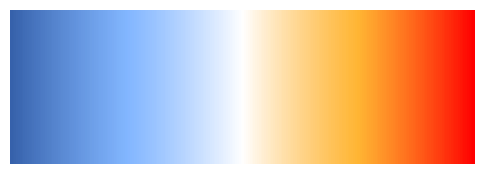

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()



In [144]:
beta1 = coefficients_per_fold[1][0,:] + intercepts_per_fold[1][0]
beta1.shape

(400,)

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


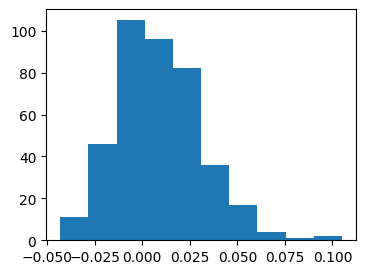

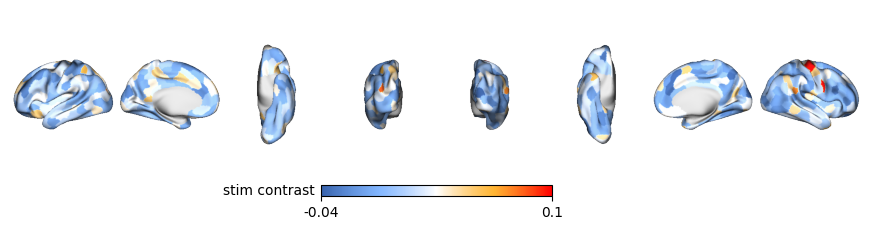

In [172]:
beta1 = coefficients_per_fold[1][0,:] + intercepts_per_fold[1][0]
first_img_beta = parc.inverse_transform(beta1)
fig = plt.figure(figsize=(4,3))
plt.hist(beta1)
plot_brain_surfaces(image=first_img_beta, cbar_label='stim contrast', cmap=cmap, color_range=(-0.04, 0.1))
# ["stim_con", "expectrating", "outcomerating", "NPSpos"]

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


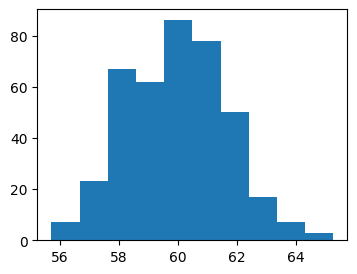

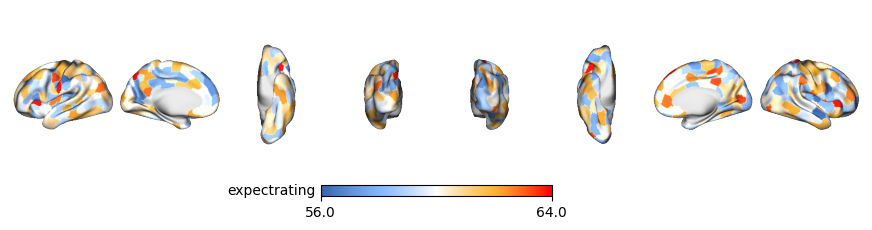

In [173]:
beta2 = coefficients_per_fold[1][1,:] + intercepts_per_fold[1][1]
second_img_beta = parc.inverse_transform(beta2)
fig = plt.figure(figsize=(4,3))
plt.hist(beta2)
plot_brain_surfaces(image=second_img_beta, cbar_label='expectrating', cmap=cmap, color_range=(56, 64))
# ["stim_con", "expectrating", "outcomerating", "NPSpos"]

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


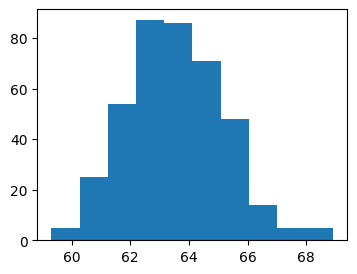

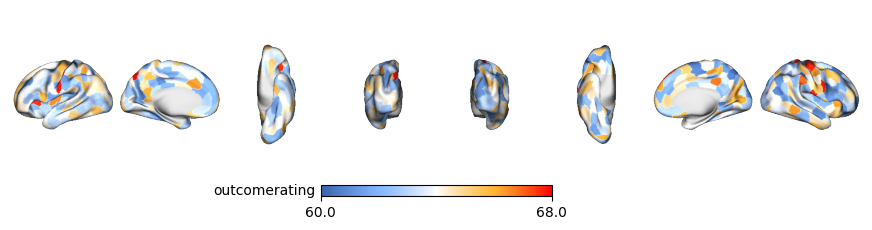

In [174]:
y3 = coefficients_per_fold[1][2,:] + intercepts_per_fold[1][2]
third_img_beta = parc.inverse_transform(y3)
fig = plt.figure(figsize=(4,3))
plt.hist(y3)
plot_brain_surfaces(image=third_img_beta, cbar_label='outcomerating', cmap=cmap, color_range=(60, 68))
# ["stim_con", "expectrating", "outcomerating", "NPSpos"]

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_34895/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


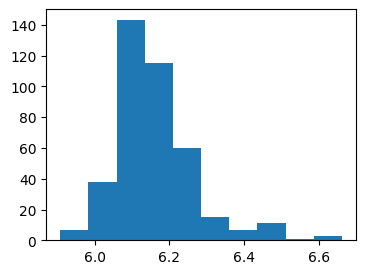

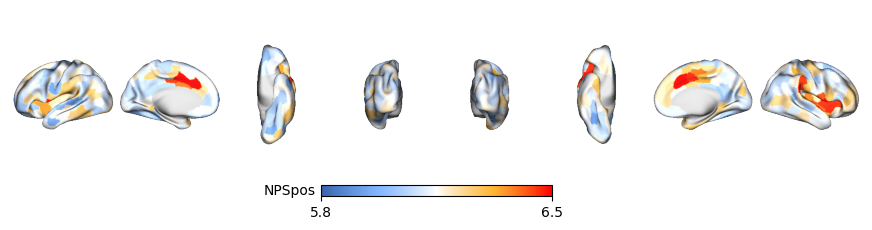

In [175]:
y4 = coefficients_per_fold[1][3,:] + intercepts_per_fold[1][3]
NPS_img_beta = parc.inverse_transform(y4)
fig = plt.figure(figsize=(4,3))
plt.hist(y4)
plot_brain_surfaces(image=NPS_img_beta, cbar_label='NPSpos', cmap=cmap, color_range=(5.8,6.5))
# ["stim_con", "expectrating", "outcomerating", "NPSpos"]

Q. how similar are the NPS maps and the PLS recovered NPS maps?

### B.4.e Y loadings

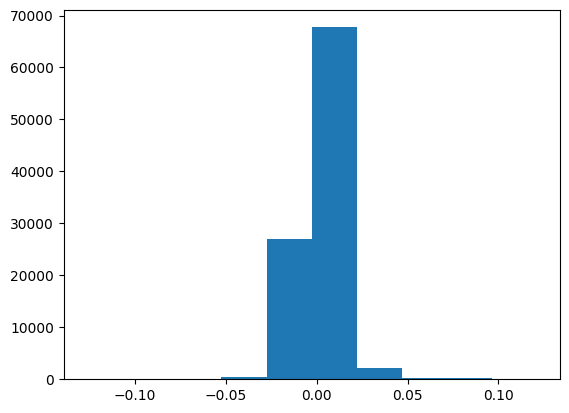

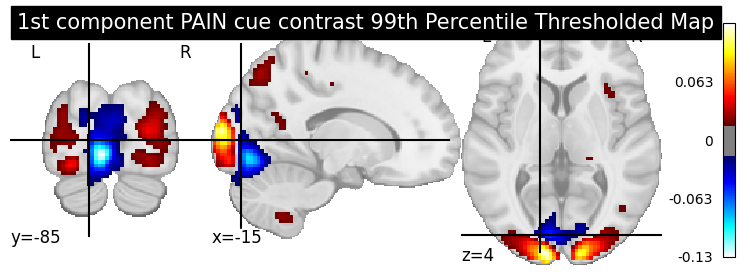

In [74]:
loadings01 = nifti_masker.inverse_transform(y_loadings[:,0])
data = loadings01.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,0])
plotting.plot_stat_map(loadings01, threshold=percentile_99, 
             title='1st component PAIN cue contrast 99th Percentile Thresholded Map')

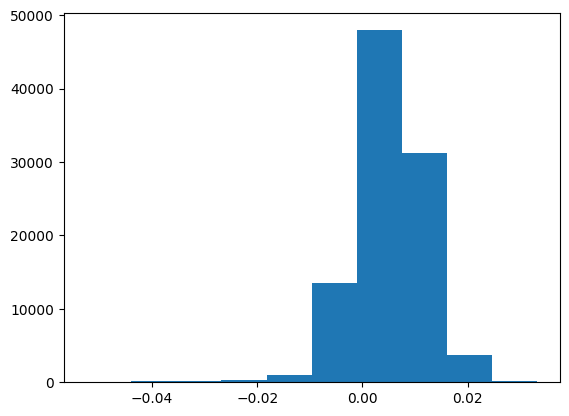

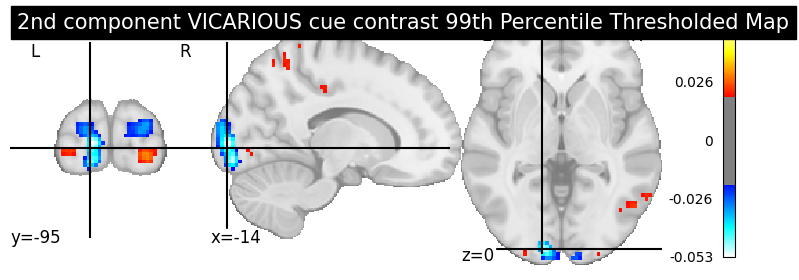

In [73]:
loadings02 = nifti_masker.inverse_transform(y_loadings[:,1])
data = loadings02.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,1])
plotting.plot_stat_map(loadings02, threshold=percentile_99, 
             title='2nd component VICARIOUS cue contrast 99th Percentile Thresholded Map')

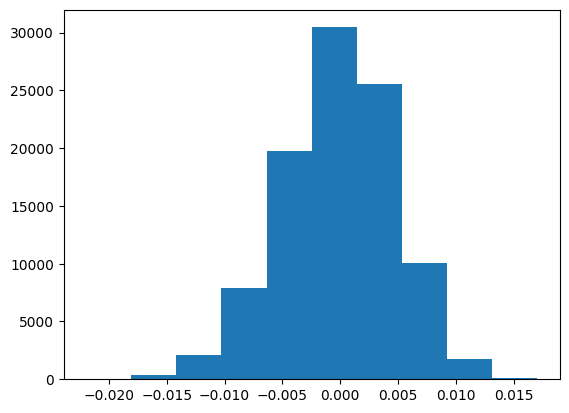

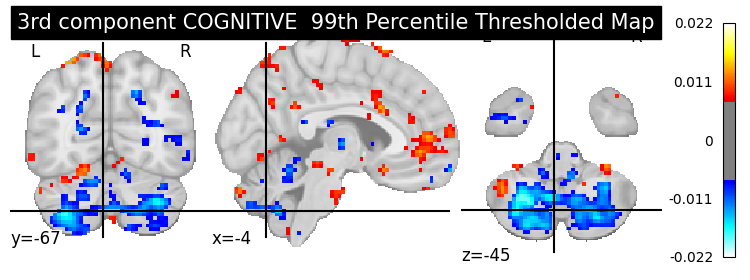

In [75]:
loadings03 = nifti_masker.inverse_transform(y_loadings[:,2])
data = loadings03.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,2])
plotting.plot_stat_map(loadings03, threshold=percentile_99, 
             title='3rd component COGNITIVE  99th Percentile Thresholded Map')

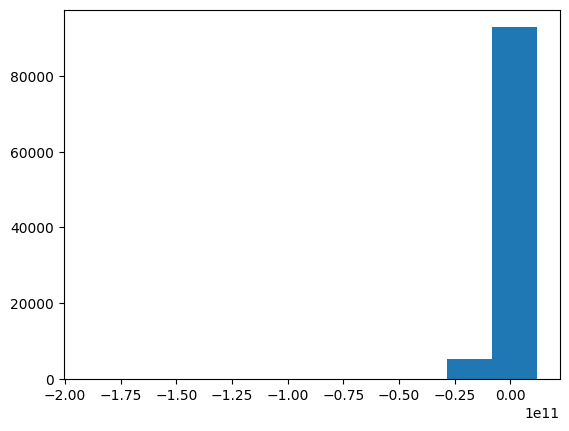

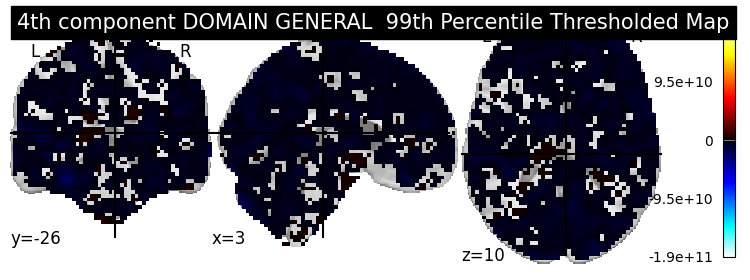

In [76]:
loadings04 = nifti_masker.inverse_transform(y_loadings[:,3])
data = loadings04.get_fdata()
percentile_99 = np.percentile(data[data != 0], 95)  # Exclude zero or background voxels if necessary

# Plot the statistical map using the 95th percentile as the threshold
plt.hist(y_loadings[:,3])
plotting.plot_stat_map(loadings04, threshold=percentile_99, 
             title='4th component DOMAIN GENERAL  99th Percentile Thresholded Map')